# import

In [1]:
import os
import math
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import copy
from qutip import *
from qutip.fileio import *
from qutip.interpolate import *
import qutip.ipynbtools as qpipy
from qutip.qip.operations import cphase as CPhase
from qutip.qip.operations import rz
from scipy.fft import fft, fftfreq
from scipy.special import erf
from scipy.interpolate import interp1d
from scipy import signal
from scipy.integrate import odeint
from scipy import linalg
from scipy.optimize import minimize , minimize_scalar
import scipy.constants as cn
import random
import cmath
import itertools
from cycler import cycler
from pynverse import inversefunc
from IPython.display import display, Math
import warnings

In [2]:
# 可交互图像
%matplotlib notebook

%config InlineBackend.figure_format = 'svg'

# 初始化

## 参数

In [2]:
device_paras={'w_g': np.array([5,  4.5 ]), \
              'w_s1': np.array([5.5 ]), \
              'alpha': -220, \
              'g_g': 10, \
              'g_s1': np.array([10 ]) }

## 希尔伯特空间

In [3]:
# 希尔伯特空间大小
Nstates = 3

a = destroy(Nstates)
a_dagger = create(Nstates)  
I = qeye(Nstates)
I3= tensor(I,I,I)
a_g1 = tensor(a,I,I)
ad_g1 = a_g1.dag()  
 
a_g2 = tensor(I,a,I)
ad_g2 = a_g2.dag()

a_s1 = tensor(I,I,a)
ad_s1 = a_s1.dag() 



ground = basis(Nstates,0)
excited = basis(Nstates,1)
leakage = basis(Nstates,2)


## 系统哈密顿量

In [4]:
def Hamiltonian(device_paras):
    w_g = [w*2.0*np.pi for w in device_paras['w_g']]
    w_s1 = [w*2.0*np.pi for w in device_paras['w_s1']]

    alpha = device_paras['alpha']*10**(-3)*2.0*np.pi

    g_g = device_paras['g_g']*10**(-3)*2.0*np.pi
    g_s1 = [g*10**(-3)*2.0*np.pi for g in device_paras['g_s1']]

    H0_g = w_g[0]*ad_g1*a_g1+w_g[1]*ad_g2*a_g2 +alpha/2.0*ad_g1*ad_g1*a_g1*a_g1+alpha/2.0*ad_g2*ad_g2*a_g2*a_g2
    H0_s1 = w_s1[0]*ad_s1*a_s1+alpha/2.0*ad_s1*ad_s1*a_s1*a_s1
    H0 = H0_g+H0_s1
    
    HI = -g_g*(a_g1-ad_g1)*(a_g2 - ad_g2)-g_s1[0]*(a_g1-ad_g1)*(a_s1-ad_s1)
    H = H0+HI
    
    return H0 ,H 
    
    
    

## 本征态

In [5]:
#定义基本的能级顺序
energy_info = {'dim':[3]*3, 'exci_num': 6, 'bas_list':[], 'bas_name_list':[]}

for bas in state_number_enumerate(energy_info['dim'], excitations=energy_info['exci_num']):
    energy_info['bas_list'].append(state_number_qobj(energy_info['dim'], bas))
    energy_info['bas_name_list'].append(''.join(map(str,bas)))
energy_info['bas_num'] = len(energy_info['bas_list'])

print(energy_info['bas_name_list'])

['000', '001', '002', '010', '011', '012', '020', '021', '022', '100', '101', '102', '110', '111', '112', '120', '121', '122', '200', '201', '202', '210', '211', '212', '220', '221', '222']


In [6]:
def eigensolve(H0,H):
    # 使用eigenstates()函数计算哈密顿量的本征态和本征矢
    ei_states = H.eigenstates() # 得到dressed states的能级变化
    ei_energy = ei_states[0]
    ei_vector = ei_states[1]
    
    ei_states0 = H0.eigenstates() # 得到bare states的能级变化
    ei_energy0 = ei_states0[0]
    ei_vector0 = ei_states0[1]
    
    states_order = ei_vector.copy()
    states0_order = ei_vector.copy()
    energy_order = ei_energy.copy()
    energy0_order = ei_energy.copy()
    for n,vector in enumerate(ei_vector0):
        try:
            index = energy_info['bas_list'].index(vector)
            states_order[index] = ei_vector[n]
            states0_order[index] = ei_vector0[n]
            energy_order[index] = ei_energy[n]
            energy0_order[index] = ei_energy0[n]            
            
        except:
            pass
    
    return states_order, states0_order , energy_order, energy0_order
    

## 计算ZZ耦合

In [7]:
def ZZcoupling(device_paras):
    H0,H = Hamiltonian(device_paras)
    states, states0, energy, energy0 =eigensolve(H0,H)

    zeta= energy[state_number_index(energy_info['dim'], [1, 0, 1])]-\
    energy[state_number_index(energy_info['dim'], [1, 0, 0])]-\
    energy[state_number_index(energy_info['dim'], [0, 0, 1])]+\
    energy[state_number_index(energy_info['dim'], [0, 0, 0])]
    return abs(zeta/(2*np.pi*10**(-3)))

# 两比特门

## 驱动脉冲

In [134]:
def pulse_2(t_list, paras_dict):
    # 计算上升沿下降沿对应的时间戳
    pulse_len = paras_dict['pulse_len']
    sigma = paras_dict['sigma']
    x_idle = device_paras['w_g'][1]
    x_work = paras_dict['w2_work']
    flattop_start = 3*sigma
    flattop_end = pulse_len - 3*sigma


    y_list = (x_work-x_idle) * 1/2*( erf( (t_list-flattop_start)/(np.sqrt(2)*sigma) ) - \
                                erf( (t_list-flattop_end)/(np.sqrt(2)*sigma) ) ) + x_idle
    return y_list

## 含时哈密顿量

In [143]:
def Hamiltonian_t(t_list, paras_dict):
    w_g = [w*2.0*np.pi for w in device_paras['w_g']]
    w2 = pulse_2(t_list, paras_dict)*2.0*np.pi
    w_s1 = [w*2.0*np.pi for w in device_paras['w_s1']]
    
    alpha = device_paras['alpha']*10**(-3)*2.0*np.pi

    g_g = device_paras['g_g']*10**(-3)*2.0*np.pi
    g_s1 = [g*10**(-3)*2.0*np.pi for g in device_paras['g_s1']]
    
    
     #插值

    w2 = Cubic_Spline(t_list[0], t_list[-1], w2)

    

    H2 = [ad_g2*a_g2, w2]

    
    H0_g = w_g[0]*ad_g1*a_g1 +alpha/2.0*ad_g1*ad_g1*a_g1*a_g1+alpha/2.0*ad_g2*ad_g2*a_g2*a_g2
    H0_s1 = w_s1[0]*ad_s1*a_s1+alpha/2.0*ad_s1*ad_s1*a_s1*a_s1
    H0 = H0_g+H0_s1
    
    HI = -g_g*(a_g1-ad_g1)*(a_g2 - ad_g2)-g_s1[0]*(a_g1-ad_g1)*(a_s1-ad_s1)
    H = H0+HI
    H = [H,H2]
    return H
    
    

## 泄漏计算

In [139]:
def par_leak(paras_dict):
    
    t_list = np.linspace(0,paras_dict['pulse_len'],300)
    
    H0,H = Hamiltonian(paras_dict)
    states, states0, energy, energy0 =eigensolve(H0,H)
    
    Ht = Hamiltonian_t(t_list, paras_dict)
    
    b11 = states[state_number_index(energy_info['dim'], [1, 1, 0])]
    psi = mesolve(Ht, b11, t_list).states[-1]
    amp11 = np.abs(psi.overlap(b11))**2

    return amp11

In [350]:
pulse_paras={'pulse_len':60,'sigma':1.2}

device_paras['g_g'] = np.pi/(np.sqrt(2)*copy.deepcopy(pulse_paras['pulse_len']))/(2*np.pi*10**(-3))

parameter=[]
w2_worklist=np.linspace(-0.1,0.1,30)+device_paras['w_g'][0]+device_paras['alpha']*10**(-3)
pulse_lenlist=np.linspace(-10,10,30)+pulse_paras['pulse_len']+10


for pulse_len in pulse_lenlist:
    for w2_work in w2_worklist:
        pulse_paras['pulse_len']=pulse_len
        pulse_paras['w2_work']=w2_work
        CZ_paras = {**device_paras,**pulse_paras}
        parameter.append(copy.deepcopy(CZ_paras))
        
result=parallel_map(par_leak, parameter, progress_bar=True,num_cpus=24)

10.0%. Run time:   1.96s. Est. time left: 00:00:00:17
20.0%. Run time:   3.34s. Est. time left: 00:00:00:13
30.0%. Run time:   4.73s. Est. time left: 00:00:00:11
40.0%. Run time:   6.14s. Est. time left: 00:00:00:09
50.0%. Run time:   7.62s. Est. time left: 00:00:00:07
60.0%. Run time:   9.05s. Est. time left: 00:00:00:06
70.0%. Run time:  10.57s. Est. time left: 00:00:00:04
80.0%. Run time:  12.16s. Est. time left: 00:00:00:03
90.0%. Run time:  13.71s. Est. time left: 00:00:00:01
100.0%. Run time:  15.21s. Est. time left: 00:00:00:00
Total run time:  15.33s


<IPython.core.display.Javascript object>


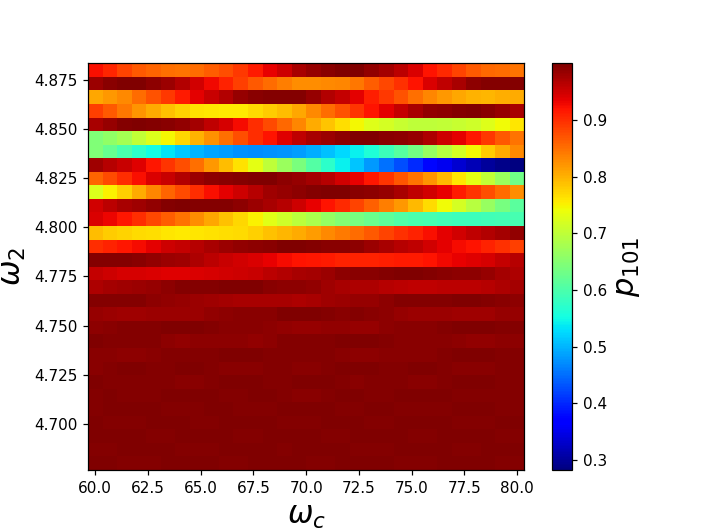

Text(0, 0.5, '$\\omega_2$')

In [351]:
#泄漏




leak_arr = np.array(result).reshape(len(pulse_lenlist),len(w2_worklist))

#plot
xx,yy = np.meshgrid(pulse_lenlist,w2_worklist)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,leak_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)

cb.set_label('$p_{101}$',fontdict=font2) 

plt.xlabel('$\omega_c$',font2)
plt.ylabel('$\omega_2$',font2)


In [268]:
max(result)

0.9999999435907191

## 受控相位计算

In [222]:
def par_cphase(paras_dict):
    t_list = np.linspace(0,paras_dict['pulse_len'],300)
    
    Ht = Hamiltonian_t(t_list, paras_dict)
    dim=energy_info['dim']

    b1x0 = 1/np.sqrt(2) * (basis(dim,[1,0,0])+basis(dim,[1,1,0]))
    b0x0 = 1/np.sqrt(2) * (basis(dim,[0,0,0])+basis(dim,[0,1,0]))
    psi1x0 = mesolve(Ht, b1x0, t_list).states[-1]
    psi0x0 = mesolve(Ht, b0x0, t_list).states[-1]
    phase1x0 = cmath.phase(psi1x0.ptrace(1)[1,0])
    phase0x0 = cmath.phase(psi0x0.ptrace(1)[1,0])
    
    cphase = phase1x0 - phase0x0
    cphase = np.arctan2(np.sin(cphase), np.cos(cphase))
    
    return cphase

In [318]:
def ptrace_me(rho,states):
    rho_2 = np.zeros([3,3],dtype='complex128')
    for i in range(3):
        for j in range(3):
            for x in range(3):
                for y in range(3):
                    for z in range(3):
                        for w in range(3):
                            rho_2[i][j] = rho_2[i][j] + (states[state_number_index(dim, [x,i,y])].dag()*rho*states[state_number_index(dim, [z,j,w])]).full()[0][0]
                    
                    
    rho_2 = Qobj(rho_2, dims=[[3],[3]])
                    
    return rho_2         
                    
                    

In [310]:
rho = psi1x0
rho_2 = np.zeros([3,3],dtype='complex128')
for i in range(1):
    for j in range(1):
        for x in range(3):
            for y in range(3):
                print((states[state_number_index(dim, [x,i,y])].dag()*rho*states[state_number_index(dim, [x,j,y])]).full()[0][0])



(0.00013963337969066076+0.00035893265357972285j)
0j
(2.7466558519517295e-06+1.2862597946886458e-06j)
0j
(-3.172318202809571e-05-9.93055061428721e-05j)
0j
(4.7001322521141316e-06+6.859634805213145e-05j)
0j
(7.370054001403467e-10+2.1720764670639127e-08j)


In [309]:
def ptrace_me1(rho,states):
    rho_2 = np.zeros([3,3],dtype='complex128')
    for i in range(2):
        for j in range(2):
            for x in range(3):
                for y in range(3):
                    rho_2[i][j] = rho_2[i][j] + (states[state_number_index(dim, [x,i,y])].dag()*rho*states[state_number_index(dim, [x,j,y])]).full()[0][0]
                    
                    
    rho_2 = Qobj(rho_2, dims=[[3],[3]])
                    
    return rho_2         
                    
                    

In [352]:
Cphase=parallel_map(par_cphase, parameter, progress_bar=True,num_cpus=24)

10.0%. Run time:   2.72s. Est. time left: 00:00:00:24
20.0%. Run time:   5.25s. Est. time left: 00:00:00:20
30.0%. Run time:   7.86s. Est. time left: 00:00:00:18
40.0%. Run time:  10.44s. Est. time left: 00:00:00:15
50.0%. Run time:  12.91s. Est. time left: 00:00:00:12
60.0%. Run time:  15.60s. Est. time left: 00:00:00:10
70.0%. Run time:  18.48s. Est. time left: 00:00:00:07
80.0%. Run time:  21.43s. Est. time left: 00:00:00:05
90.0%. Run time:  24.40s. Est. time left: 00:00:00:02
100.0%. Run time:  27.48s. Est. time left: 00:00:00:00
Total run time:  27.58s


<IPython.core.display.Javascript object>


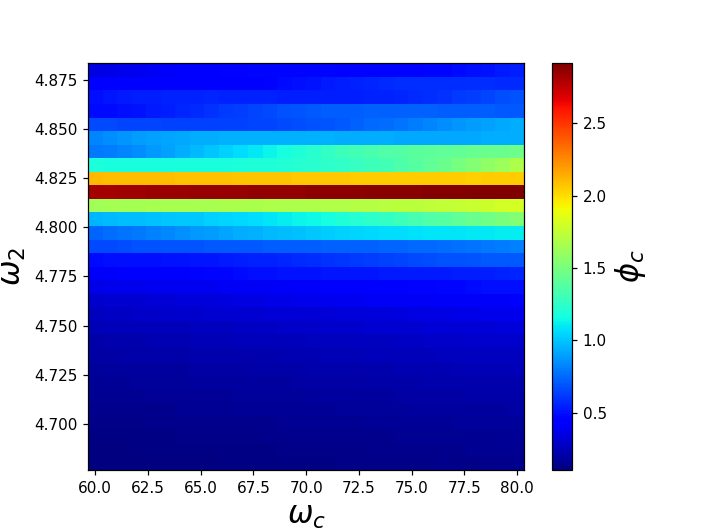

Text(0, 0.5, '$\\omega_2$')

In [353]:
cphase_arr = np.array(Cphase).reshape(len(pulse_lenlist),len(w2_worklist))

#plot
xx,yy = np.meshgrid(pulse_lenlist,w2_worklist)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,abs(cphase_arr).T,cmap='jet')
cb=plt.colorbar(c, ax=ax)

cb.set_label('$\phi_c$',fontdict=font2) 

plt.xlabel('$\omega_c$',font2)
plt.ylabel('$\omega_2$',font2)

In [271]:
np.pi-max(Cphase)

0.13889855948393492

## 保真度计算

In [225]:
def Fidelity_CZ(U):
    U_CZ = CPhase(theta=np.pi)
#     error =1-abs(np.trace(np.dot(U.dag(),U))+(abs(np.trace(np.dot(U_CZ.dag(),U)))** 2))/20
    I = qeye(2)
    
    f = lambda phi :  1-abs(np.trace(np.dot((tensor(rz(phi[0]),I)*tensor(I,rz(phi[1]))*U).dag(),(tensor(rz(phi[0]),I)*tensor(I,rz(phi[1]))*U)))+(abs(np.trace(np.dot(U_CZ.dag(),(tensor(rz(phi[0]),I)*tensor(I,rz(phi[1]))*U))))** 2))/20

    res = minimize(f,[0,0],method='SLSQP')
    error =res.fun
    return error

In [366]:
def par_fidelity(paras_dict,n):
    dim=energy_info['dim']
    t_list = np.linspace(0,paras_dict['pulse_len'],300)
    H0,H = Hamiltonian(paras_dict)
    states, states0, energy, energy0 =eigensolve(H0,H)

    Ht = Hamiltonian_t(t_list, paras_dict)
    U_uncali = propagator(Ht, t_list)[-1]
    
    
    idx00 = state_number_index(dim, [0,0,n]); 
    idx01 = state_number_index(dim, [0,1,n]); 
    idx10 = state_number_index(dim, [1,0,n]); 
    idx11 = state_number_index(dim, [1,1,n]);
#     U = Qobj(U_cali[[0,idx01,idx10,idx11],:][:,[0,idx01,idx10,idx11]], dims=[[2,2],[2,2]])
    basis_calcu = [idx00,idx01,idx10,idx11]
    U=np.zeros([4,4],dtype='complex128')
    for i in range(4):
        for j in range(4):
            U[i][j] = (states[basis_calcu[i]].dag()*U_uncali*states[basis_calcu[j]]).full()[0][0]
    U=Qobj(U, dims=[[2,2],[2,2]])
    error = Fidelity_CZ(U)
  
    
    
    
    return error

In [227]:
error=parallel_map(par_fidelity, parameter, progress_bar=True,num_cpus=24)

10.0%. Run time:  21.07s. Est. time left: 00:00:03:09
20.0%. Run time:  41.70s. Est. time left: 00:00:02:46
30.0%. Run time:  62.63s. Est. time left: 00:00:02:26
40.0%. Run time:  80.19s. Est. time left: 00:00:02:00
50.0%. Run time: 100.49s. Est. time left: 00:00:01:40
60.0%. Run time: 121.41s. Est. time left: 00:00:01:20
70.0%. Run time: 142.66s. Est. time left: 00:00:01:01
80.0%. Run time: 160.88s. Est. time left: 00:00:00:40
90.0%. Run time: 181.89s. Est. time left: 00:00:00:20
100.0%. Run time: 203.24s. Est. time left: 00:00:00:00
Total run time: 203.36s


<IPython.core.display.Javascript object>


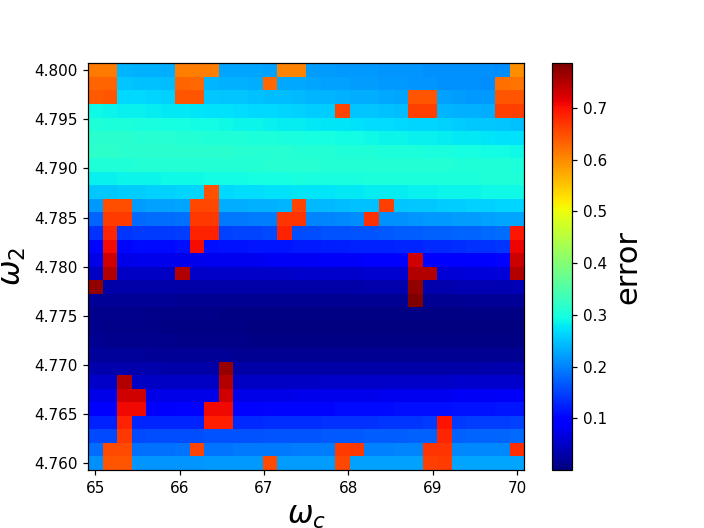

Text(0, 0.5, '$\\omega_2$')

In [228]:
error_list = [e for e in error]
error_arr = np.array(error_list).reshape(len(pulse_lenlist),len(w2_worklist))

#plot
xx,yy = np.meshgrid(pulse_lenlist,w2_worklist)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,error_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)

cb.set_label('error',fontdict=font2) 

plt.xlabel('$\omega_c$',font2)
plt.ylabel('$\omega_2$',font2)



In [229]:
min(error)

1.7456492923395572e-05

## 两比特门校准

In [367]:
def calibration_F(paras,device_paras,n):
    pulse_paras = {'sigma':1.2}
    pulse_paras['pulse_len'] = paras[0]
    pulse_paras['w2_work'] = paras[1]
    CZ_paras = {**device_paras,**pulse_paras}

    
    error = par_fidelity(CZ_paras,n)
    error_list.append(error)
    return error 
    
    
    

In [365]:
def calibration_leak(paras,device_paras):
    pulse_paras = {'sigma':1.2}
    pulse_paras['pulse_len'] = paras[0]
    pulse_paras['w2_work'] = paras[1]
    CZ_paras = {**device_paras,**pulse_paras}
    
    
    error = 1-par_leak(CZ_paras)+(np.pi-abs(par_cphase(CZ_paras)))/np.pi
    
    error_list.append(error)
    return error
    
    
    

In [323]:
def calibration_cphase(paras,device_paras):
    pulse_paras = {'sigma':1.2}
    pulse_paras['pulse_len'] = paras[0]
    pulse_paras['w2_work'] = paras[1]
    CZ_paras = {**device_paras,**pulse_paras}

    
    error = np.pi-abs(par_cphase(CZ_paras))
    
    error_list.append(error)
    return error
    
    
    

In [276]:
def _EPGback(argi):
    global count

    if count%1 == 0:
        end=time.time()
        print('iter:{:d}  error:{:f}  {}  {:2f}'.format(count, error_list[-1] ,argi,end-start)) 
    count += 1

In [432]:


device_paras = parameter[0]

x0 = [68,device_paras['w_g'][0]+device_paras['alpha']*10**(-3)]
bounds = ((x0[0]-5,x0[0]+5),(x0[1]-0.07,x0[1]+0.07) )

start = time.time();count=0;error_list = [];
nm_result = minimize(calibration_leak, x0 ,args=(device_paras,),bounds=bounds, method='Nelder-Mead', callback=_EPGback)

calibration_F(nm_result.x,device_paras,0)

iter:0  error:0.875382  [68.    4.78]  3.772229
iter:1  error:0.959656  [68.    4.78]  6.772676
iter:2  error:0.582564  [68.    4.78]  8.268578
iter:3  error:0.274833  [68.    4.78]  9.761492
iter:4  error:0.125663  [68.    4.78]  11.253549
iter:5  error:0.058850  [68.    4.78]  12.742519
iter:6  error:0.025748  [68.    4.78]  14.230904
iter:7  error:0.009255  [68.    4.78]  15.720387
iter:8  error:0.004269  [67.78251953  4.78020508]  17.187560
iter:9  error:0.002949  [68.36730957  4.78018799]  18.652140
iter:10  error:0.002978  [68.36730957  4.78018799]  20.125200
iter:11  error:0.001582  [68.41231537  4.78011215]  21.606365
iter:12  error:0.001071  [68.21363487  4.78012417]  23.087272
iter:13  error:0.000828  [68.34014235  4.78015307]  24.570128
iter:14  error:0.000678  [68.20917523  4.78015186]  26.047950
iter:15  error:0.000175  [68.24414683  4.78013832]  27.526295
iter:16  error:0.000474  [68.24414683  4.78013832]  28.267131
iter:17  error:0.000254  [68.24414683  4.78013832]  29.7

1.3317101327237069e-06

In [435]:
error_0_list = []
error_1_list = []

for device_paras in parameter:

    x0 = [68,device_paras['w_g'][0]+device_paras['alpha']*10**(-3)]
    bounds = ((x0[0]-4,x0[0]+4),(x0[1]-0.05,x0[1]+0.05) )


    nm_result = minimize(calibration_leak, x0 ,args=(device_paras,),bounds=bounds, method='Nelder-Mead')

    error_0_list.append(calibration_F(nm_result.x,device_paras,0))
    error_1_list.append(calibration_F(nm_result.x,device_paras,1))
    print(error_0_list[-1],len(error_0_list))


9.310079718272135e-07 1
9.334878420252934e-07 2
9.361642318017616e-07 3
9.384905247378228e-07 4
9.408665505583613e-07 5
9.432577032786327e-07 6
9.452650413521724e-07 7
9.473251534330984e-07 8
9.493662357362709e-07 9
9.512371056397129e-07 10
9.53046882634645e-07 11
9.549000303810118e-07 12
9.56586472256049e-07 13
9.582857533052547e-07 14
9.598694600265745e-07 15
0.3999883438144416 16
9.6198902266309e-07 17
9.634348202558485e-07 18
9.6487744760676e-07 19
9.6620867418018e-07 20
0.41286186571321903 21
9.687371027577996e-07 22
9.699653024108912e-07 23
9.71162996021846e-07 24
9.722981584303625e-07 25
9.733824741786634e-07 26
9.743674149742532e-07 27
9.753756351482679e-07 28
9.763496624515255e-07 29
9.772732811885732e-07 30
9.781501280059501e-07 31
9.790010381260927e-07 32
9.79799748335175e-07 33
9.805975000887202e-07 34
9.81325079862927e-07 35
9.820228534795916e-07 36
9.827058928824073e-07 37
9.833904647260638e-07 38
9.840147221495954e-07 39
9.846217045028638e-07 40
9.852113990183042e-07 41


5.313386489680383e-07 322
6.512211614406738e-07 323
5.569206363853496e-07 324
5.554889870307278e-07 325
5.573958002935697e-07 326
5.668379753354102e-07 327
5.74222280391723e-07 328
1.039758793175416e-06 329
1.0776331796913396e-06 330
1.1095704254282523e-06 331
4.797495675168406e-07 332
1.037253951396977e-06 333
1.3407957657474157e-06 334
1.0032742681076456e-06 335
5.090324464163132e-07 336
1.047958314459585e-06 337
9.245067449370481e-07 338
4.4454061909338094e-07 339
6.345512015837329e-07 340
6.746526430845279e-07 341
7.836935171923187e-07 342
0.8000002678053564 343
0.042885760586842125 344
0.00026952702269800177 345
7.677996343335991e-05 346
0.16593138230932214 347
0.2947361410042403 348
0.43812182883433604 349
4.68108388385069e-06 350
5.666997218156666e-07 351
-8.66452167791465e-08 352
1.7903755455961345e-07 353
2.4227365236217935e-07 354
3.582859988693343e-07 355
2.788658722829851e-07 356
3.1926146459859694e-07 357
3.8000111679536985e-07 358
7.230265278712622e-07 359
8.3908413173183

1.2977099024924499e-05 638
4.713342563134049e-06 639
1.6002427603023506e-06 640
7.649997690872823e-07 641
-1.714612940517668e-08 642
-2.1261390226179344e-07 643
2.8186586542577885e-07 644
-1.7631664084305498e-07 645
3.913141040090551e-07 646
6.408312813732664e-08 647
-6.555432885413381e-08 648
-7.449668704140322e-08 649
-1.2707579433168803e-08 650
1.0226027513660085e-07 651
1.3322917213898222e-08 652
1.023037301539631e-07 653
5.390883295319782e-09 654
2.552544842160387e-08 655
3.600936326897397e-08 656
-3.1023628555004734e-08 657
-6.995761703265657e-08 658
-1.9846708720905326e-09 659
5.982580517649438e-07 660
-2.170633939257982e-08 661
1.989218789688607e-07 662
7.412975677745237e-09 663
-2.1702287744673754e-08 664
-4.6631257966112116e-08 665
2.0445881849795455e-06 666
2.3309842289709337e-07 667
1.4323976027519336e-07 668
4.6255788943572185e-07 669
3.266708640703442e-06 670
1.1183236417799947e-05 671
0.0020487186398818746 672
0.5417689835582615 673
0.008167822519978274 674
0.52774359498

1.331130959902893e-07 949
2.192844027470997e-07 950
4.996837672521792e-07 951
8.40592518036587e-07 952
8.586222470796656e-07 953
1.2913716730400537e-06 954
2.063342726232875e-06 955
3.379032457728748e-06 956
5.809347819463184e-06 957
2.257709453634682e-05 958
0.22049706687783854 959
0.0005847417060934612 960
0.06646592576517119 961
0.35571394462474126 962
0.5024021099938534 963
0.4289821894089263 964
0.799914047741649 965
4.2378268272358355e-07 966
1.552959484407701e-05 967
1.2126189043781821e-05 968
7.242052867839632e-06 969
4.024536403468559e-06 970
2.186827986472295e-06 971
1.1965365480648416e-06 972
7.317486595548317e-07 973
2.997976826790705e-07 974
1.7324124923501216e-07 975
-4.912798035050514e-08 976
-7.817656344499824e-08 977
-1.4147268312392214e-07 978
-2.3521367364942591e-07 979
-2.605719353621083e-07 980
-2.6084038529106124e-07 981
-2.482104168866073e-07 982
-2.3558255612954326e-07 983
-2.9783035104813393e-07 984
1.1331170102213406e-07 985
4.819451424609156e-07 986
2.5004204

1.2056895276613133e-05 1257
8.956787043601366e-06 1258
6.416336129078104e-06 1259
4.634680828785598e-06 1260
3.675728106555809e-06 1261
2.5749622952764284e-06 1262
1.9413941151347203e-06 1263
1.4893654677328172e-06 1264
1.6437930824286795e-06 1265
9.176165347568599e-07 1266
7.090576126245196e-07 1267
5.478521121204949e-07 1268
7.431121374912308e-07 1269
3.9315426081376614e-07 1270
2.9343897833822297e-07 1271
1.6433902825241375e-06 1272
1.75145222880424e-06 1273
2.0209448369223892e-06 1274
2.089462085352878e-06 1275
2.320946983935812e-06 1276
0.7999992400725013 1277
3.5097030904873705e-06 1278
4.157712205077324e-06 1279
4.716661729076144e-06 1280
5.808867963752462e-06 1281
0.4687091680604649 1282
9.732831054543034e-06 1283
0.23999312398360917 1284
0.20516553395420067 1285
2.3778814234765022e-05 1286
0.002815687019662505 1287
0.7601205103971406 1288
0.29608037269214293 1289
0.4301416600301322 1290
0.09600354640413489 1291
0.4210320373497678 1292
0.003152977592905004 1293
3.26174738318751

0.46809543872810677 1565
6.384549090965308e-06 1566
7.981568266424155e-06 1567
0.23852068840098273 1568
0.2188506083793692 1569
1.5240805186444994e-05 1570
1.673216184605586e-05 1571
1.8065371654829576e-05 1572
0.07287096789011827 1573
0.0499403680572742 1574
0.5821964720261703 1575
0.45590658764093406 1576
0.42454228193691546 1577
0.45556497089047276 1578
0.4268315324403764 1579
0.006451990195687984 1580
2.8667555960537605e-05 1581
2.6756991511001083e-05 1582
-1.003150010614462e-06 1583
4.719034804701039e-06 1584
1.2578450978240063e-05 1585
1.4794283346275527e-05 1586
1.383928755571695e-05 1587
1.2154955830290248e-05 1588
1.0361448422258057e-05 1589
8.797206238475574e-06 1590
7.562564867669153e-06 1591
6.558938129730407e-06 1592
5.601515540853974e-06 1593
5.113516833743503e-06 1594
4.33955290757293e-06 1595
3.892792903359421e-06 1596
3.553460728333846e-06 1597
1.199798610651559e-05 1598
3.342539951156631e-06 1599
0.588200583475309 1600
4.204155690579192e-06 1601
4.663679595728887e-06 

1.2238525831653746e-05 1878
1.1503867981765836e-05 1879
1.0455355991645376e-05 1880
9.716528298397975e-06 1881
9.590786826718656e-06 1882
9.092760199891359e-06 1883
8.228692168765761e-06 1884
7.658596099524573e-06 1885
7.1662662461946525e-06 1886
9.055996317286485e-06 1887
9.22564494310052e-06 1888
9.644476019587955e-06 1889
1.0244237326872963e-05 1890
0.23897949263972573 1891
0.5710614908044108 1892
0.583849614238944 1893
0.1996652834640289 1894
1.3382363776903716e-05 1895
1.3679038941560862e-05 1896
1.3094557739234958e-05 1897
1.028608162090272e-05 1898
0.08983240416665894 1899
0.00039124159618619814 1900
0.13430624932635848 1901
0.572848041301605 1902
0.19387723030531367 1903
0.36670977140590166 1904
0.41939119640722433 1905
0.38793150815187416 1906
0.19512934778293844 1907
0.46322941069767976 1908
0.3192426095180382 1909
0.3133177038288587 1910
0.31015217418345775 1911
0.49319412917034744 1912
0.2013732790563021 1913
-2.3661284935805327e-06 1914
3.2741072970576823e-06 1915
6.561067

In [8]:
path='数据/ZZ耦合阈值/detune和wc对两比特保真度的影响'
qsave([parameter,error_0_list,error_1_list],path)

NameError: name 'parameter' is not defined

In [9]:
path='数据/ZZ耦合阈值/detune和wc对两比特保真度的影响'
parameter,error_0_list,error_1_list = qload(path)

Loaded list object.


In [10]:
##计算ZZ耦合
zeta_list = parallel_map(ZZcoupling, parameter, progress_bar=True,num_cpus=24) 

10.0%. Run time:   1.11s. Est. time left: 00:00:00:09
20.0%. Run time:   1.88s. Est. time left: 00:00:00:07
30.0%. Run time:   2.70s. Est. time left: 00:00:00:06
40.0%. Run time:   3.46s. Est. time left: 00:00:00:05
50.0%. Run time:   4.24s. Est. time left: 00:00:00:04
60.0%. Run time:   5.01s. Est. time left: 00:00:00:03
70.0%. Run time:   5.78s. Est. time left: 00:00:00:02
80.0%. Run time:   6.58s. Est. time left: 00:00:00:01
90.0%. Run time:   7.37s. Est. time left: 00:00:00:00
100.0%. Run time:   8.12s. Est. time left: 00:00:00:00
Total run time:   8.17s


In [385]:
calibration_F(nm_result.x,device_paras,0)

7.097112600940036e-07

In [386]:

error_1 = [error[1] for error in error_s1]
work_point_list = [error[2] for error in error_s1]


In [425]:
def par_CZ_with_s(device_paras):
    
    
    
    
    
    x0 = [68,device_paras['w_g'][0]+device_paras['alpha']*10**(-3)]
    bounds = ((x0[0]-5,x0[0]+5),(x0[1]-0.07,x0[1]+0.07) )

    nm_result = minimize(calibration_F, x0 ,args=(device_paras,0),bounds=bounds, method='Nelder-Mead')
    
    error_0 = calibration_F(nm_result.x,device_paras,0)
    error_1 = calibration_F(nm_result.x,device_paras,1)
    
    
    
    return error_0, error_1, nm_result.x
    
    
    
    
    
    
    
    

Text(0, 0.5, '$\\omega_2(GHz)$')

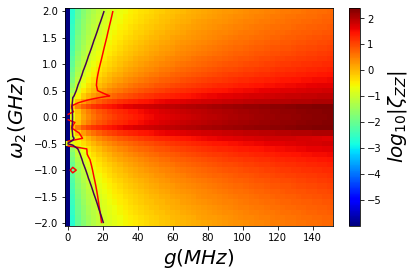

In [18]:
zeta_list_log = [math.log(abs(e+0.000001),10) for e in zeta_list]
zeta_arr = np.array(zeta_list_log).reshape(len(g_s1list),len(detune_list))

#plot
xx,yy = np.meshgrid(g_s1list,detune_list)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,zeta_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)
plt.contour(xx,yy,error_arr.T,[-3],cmap='hsv')
plt.contour(xx,yy,zeta_arr.T,[-1])
cb.set_label('$log_{10}|\zeta_{ZZ}|$',fontdict=font2) 

plt.xlabel('$g(MHz)$',font2)
plt.ylabel('$\omega_2(GHz)$',font2)

In [13]:
41*51

2091

In [15]:
detune_list = np.linspace(-2,2,41)
g_s1list = np.linspace(0,150,51)

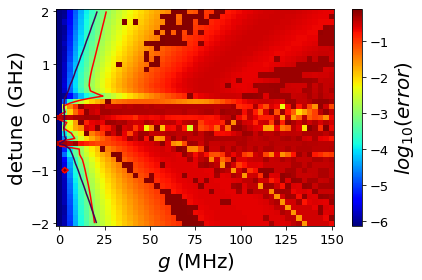

In [20]:
error_list = [math.log(abs(e),10) for e in error_1_list]
error_arr = np.array(error_list).reshape(len(g_s1list),len(detune_list))

#plot
xx,yy = np.meshgrid(g_s1list,detune_list)

font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
c = ax.pcolormesh(xx,yy,error_arr.T,cmap='jet')
cb=plt.colorbar(c, ax=ax)
plt.contour(xx,yy,error_arr.T,[-3],cmap='hsv')
plt.contour(xx,yy,zeta_arr.T,[-1])
cb.set_label('$log_{10}(error)$',fontdict=font2) 
cb.ax.tick_params(labelsize=13)
plt.xlabel('$g$ (MHz)',font2)
plt.ylabel('detune (GHz)',font2)

plt.tick_params(labelsize=13)

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.tight_layout()
plt.savefig('./图片/test.svg', dpi=600)

In [487]:
path='图片/ZZ耦合搜索结果/两比特门保真度'
plt.savefig(path+'.png', dpi=500, bbox_inches='tight')

In [416]:
len(error_s1)

2050